In [1]:
import psycopg2
from postgis.psycopg import register
import project_path
from db_importer.settings import *
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()
 
        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()


In [2]:
from shapely.geometry import Point
from shapely.geometry import box

start_rect = box(13.3158,52.5116,13.3168,52.5128)
end_rect = box(13.3137,52.5109,13.3157,52.5114)

def crop_intersection_SimRa(x):
    mask_first = x.coords.apply(lambda x: start_rect.contains(Point(x)))
    mask_end = x.coords.apply(lambda x: end_rect.contains(Point(x)))
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x.loc[first:last]
    except:
        print('check')
        
def crop_intersection_SUMO(x):
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x[['vehicle_x', 'vehicle_y']].loc[first:last].to_numpy()
    except:
        asasd = 12
        #print('check')
        
        

def plot_location(x, color, alpha, scatter):
    lon = []
    lat = []
    for c in x.coords.values:
        lon.append(c[0])
        lat.append(c[1])
    plt.plot(lon, lat, c=color, alpha=alpha)
    if scatter:
        zero_v_coords = x.apply(lambda x: x.coords if x.velos == 0 else None,axis = 1)
        lon = []
        lat = []
        for c in zero_v_coords.values:
            if c == None:
                continue
            lon.append(c[0])
            lat.append(c[1])
        plt.scatter(lon, lat)
        
                
def to_float_arr(x):
    res = []
    for c in x:
        res.append(float(c))
    return res

In [4]:
with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       json_array_elements_text(st_asgeojson(geom_raw) :: json -> 'coordinates') AS coordinates,
       unnest(timestamps)                             timestamps,
       unnest(velos)                                  velos
FROM ride
where 
            st_intersects(geom, st_setsrid(
            st_makebox2d(st_makepoint(13.3153,52.5123), st_makepoint(13.3178,52.5134)), 4326))
        AND 
            st_intersects(geom,st_setsrid( st_makebox2d( st_makepoint(13.3137,52.5109), st_makepoint(13.3157,52.5114)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])
    df = df[~df.coords.isnull()]
    df.coords = df.coords.apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    df.coords = df.coords.apply(lambda x: to_float_arr(x))
    
    grouped = df.groupby('filename', as_index=False)
    crops = grouped.apply(lambda x: crop_intersection_SimRa(x))


check
check
check


In [5]:
df_default = pd.read_csv('../sim_data/bismarck_default.csv', delimiter=';')    
df_im = pd.read_csv('../sim_data/bismarck_im.csv', delimiter=';')    
df_im_lane = pd.read_csv('../sim_data/bismarck_im_lane_only.csv', delimiter=';')    

dfs=[df_default, df_im_lane]

df_data = []
for df in dfs:
    res = df.groupby('vehicle_id').apply(lambda x: crop_intersection_SUMO(x)).dropna()
    df_data.append(res.to_numpy())

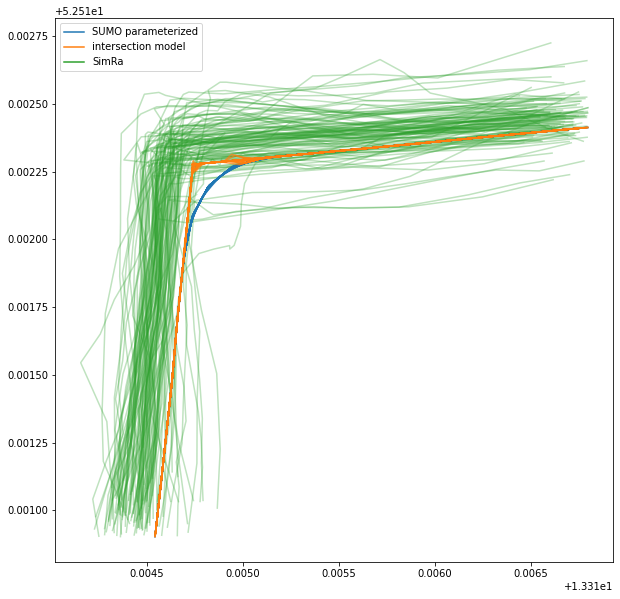

In [6]:
## Here the lane only appraoch is shown. For default intersection model, change the dfs in previous cell accordingly.

map_data = plt.figure(figsize=(10,10))
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

crops.groupby('filename').apply(lambda x: plot_location(x, colors[2], 0.3, False))
for ride in df_data[0]:
    plt.plot(ride[:,0], ride[:,1],c =colors[0], alpha=.7)
for ride in df_data[1]:
    plt.plot(ride[:,0], ride[:,1],c =colors[1], alpha=.7)

# draw temporary lines and use them to create a legend
plt.plot([], c=colors[0], label='SUMO parameterized')
plt.plot([], c=colors[1], label='intersection model')
plt.plot([], c=colors[2], label='SimRa')

plt.legend()
plt.savefig('images/im_bismarck_lane_loc.png', bbox_inches='tight')

plt.show()



In [7]:
## Damit der läuft, muss die Legend aus den Plots ausgespart werden. Bug auf seiten mplleaflet.

import mplleaflet
mplleaflet.display(fig=map_data)

AttributeError: 'XAxis' object has no attribute '_gridOnMajor'